In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


In [14]:
from keras_hub.tokenizers import WordPieceTokenizer, compute_word_piece_vocabulary
import tensorflow as tf
import keras
from keras import layers, optimizers

# Data Processing

In [2]:
data = pd.read_csv("/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv")
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
data = data.loc[:,"statement":]
data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [4]:
data = data.rename(columns = {"statement":"text", "status" : "label"})
data

,text,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [5]:
data['label'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [6]:
from sklearn.preprocessing import OrdinalEncoder
encode = OrdinalEncoder()
data['label'] = encode.fit_transform(data['label'].values.reshape(-1, 1)).astype(int)
data['label'].unique()

array([0, 3, 2, 6, 5, 1, 4])

In [7]:
data.isnull().any()

text      True
label    False
dtype: bool

In [8]:
data = data.dropna(axis = 0)
data

,text,label
0,oh my gosh,0
1,"trouble sleeping, confused mind, restless hear...",0
2,"All wrong, back off dear, forward doubt. Stay ...",0
3,I've shifted my focus to something else but I'...,0
4,"I'm restless and restless, it's been a month n...",0
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,0
53039,"selfishness ""I don't feel very good, it's lik...",0
53040,Is there any way to sleep better? I can't slee...,0
53041,"Public speaking tips? Hi, all. I have to give ...",0


In [9]:
data.isnull().any()

text     False
label    False
dtype: bool

In [10]:
from sklearn.model_selection import train_test_split
train_df, other = train_test_split(
    data,
    test_size = 0.2,
    random_state = 9700,
    shuffle = True,
    stratify = data['label'],
)

In [11]:
val_df, test_df = train_test_split(
    other,
    test_size = 0.5,
    random_state = 9700,
    shuffle = True,
    stratify = other['label'],
)

In [12]:
len(train_df), len(val_df) ,len(test_df)

(42144, 5268, 5269)

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_df['text'].values, train_df['label'].values))
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['label'].values)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['label'].values)
)

In [17]:
BATCH_SIZE = 64
MAX_SEQLEN = 512
auto = tf.data.AUTOTUNE

EMBED_DIM = 128
INTERMEDIATE_DIM = 4 * EMBED_DIM

In [18]:
# convert the text to lowercase
train_dataset = train_dataset.map(lambda text, label: (tf.strings.lower(text), label))
val_dataset = val_dataset.map(lambda text, label: (tf.strings.lower(text), label))
test_dataset = test_dataset.map(lambda text, label: (tf.strings.lower(text), label))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(auto)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(auto)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(auto)

In [19]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f"{text_batch.numpy()[i]}\n{label_batch.numpy()[i]}\n")

b'i dread waking up in the morning. the days are lifeless, pointless, all of it. nighttime is when i only begin to feel a sense of happiness but that is mostly because ill get to sleep again soon and escape. sooner or later a decision to die or get back up and fight will have to be made. i feel as time goes on it leans more towards inevitable suicide i have isolated myself and have no desire to do anything during the day other than contemplate suicide. i have the means to do it but not sure if i actually can. i have practiced the motions and all of it. just a matter of pulling the trigger at some point.'
6

b'i desperately needed to make a appointment at a clinic that i ve been putting it off for week but today i finally did it i didn t even overthink at all i love that i am finally breaking out of my shell'
2

b'i am going insane, no matter what i do, no matter who i talk to, no matter what i just want to die constantly. i miss her so much and i cannot move on, i have tried i am even 

In [20]:
reserved_tokens = ["[PAD]", "[UNK]"]

#Calculate Vocabulary Size
vocabulary = set()
train_df['text'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

121264


In [21]:
def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1024).prefetch(2),
        vocabulary_size=vocabulary_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [24]:
vocab = train_word_piece(train_dataset, vocabulary_size, reserved_tokens)

In [25]:
tokenizer = WordPieceTokenizer(
    vocabulary = vocab,
    lowercase = False,
    sequence_length = MAX_SEQLEN,
)

In [26]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b'i dread waking up in the morning. the days are lifeless, pointless, all of it. nighttime is when i only begin to feel a sense of happiness but that is mostly because ill get to sleep again soon and escape. sooner or later a decision to die or get back up and fight will have to be made. i feel as time goes on it leans more towards inevitable suicide i have isolated myself and have no desire to do anything during the day other than contemplate suicide. i have the means to do it but not sure if i actually can. i have practiced the motions and all of it. just a matter of pulling the trigger at some point.', shape=(), dtype=string)
Tokens:  tf.Tensor(
[  48 1918 1278  358  329  319  700   15  319  499  363 5345   13 1419
   13  345  322  321   15 7707  325  360   48  394 1438  317  342   40
  782  322  926  330  327  325 1014  353  662  355  317  514  444  677
  318 1190   15 2477  343  714   40 1304  317  460  343  355  407  358
  318  896  364  326  317  339  505   

In [34]:
def format_dataset(sentence, label):
    return sentence, label

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(BATCH_SIZE * 8).prefetch(16).cache()
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [50]:
from keras_hub.layers import TokenAndPositionEmbedding, FNetEncoder
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
def EmoAkinator():
    input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")
    x = TokenAndPositionEmbedding(
        vocabulary_size=vocabulary_size,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero=False,
    )(input_ids)
    x = layers.Bidirectional(
        layers.LSTM(
            64, 
            activation = "tanh", 
            kernel_regularizer=regularizers.l2(0.001),
            use_cudnn=False))(x)
    outputs = Dense(7, activation="sigmoid")(x)
    # Compile the model
    model = Model(input_ids, outputs, name="BiEscalator")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=3e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [51]:
EmoAkinator1= EmoAkinator()
EmoAkinator1.summary()

Model: "BiEscalator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_2       │ (None, None, 128)           │      15,587,328 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,687,047 (59.84 MB)

 Trainable params: 15,687,047 (59.84 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
for inputs, targets in train_dataset.take(1):
    input_ids = inputs["input_ids"]
    break
embedding_layer = EmoAkinator1.layers[1]
mask = embedding_layer.compute_mask(input_ids)
print("Computed mask:", mask)

Computed mask: None


In [53]:
reduceLR = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.0973,
    patience = 3,
    verbose = 1,
    mode = "auto",
    min_delta = 1e-4,
    cooldown = 0,
    min_lr = 0,
)
earlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0.001,
    patience = 10,
    verbose = 2,
    mode = "auto",
    restore_best_weights = True,
)
history = EmoAkinator1.fit(
    train_dataset,
    epochs=50, 
    validation_data=val_dataset,
    callbacks=[earlyStop, reduceLR]
)

Epoch 1/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4973 - loss: 1.5017 - val_accuracy: 0.6143 - val_loss: 0.9434 - learning_rate: 3.0000e-04
Epoch 2/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.6295 - loss: 0.8938 - val_accuracy: 0.6775 - val_loss: 0.8238 - learning_rate: 3.0000e-04
Epoch 3/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.6885 - loss: 0.7777 - val_accuracy: 0.7050 - val_loss: 0.7937 - learning_rate: 3.0000e-04
Epoch 4/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.7438 - loss: 0.6760 - val_accuracy: 0.7388 - val_loss: 0.7122 - learning_rate: 3.0000e-04
Epoch 5/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.7880 - loss: 0.5786 - val_accuracy: 0.7635 - val_loss: 0.6705 - learning_rate: 3.0000e-04
Epoch 6/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.8129 - loss: 0.5109 - val_accuracy: 0.7705 - val_loss: 0.6630 - learning_rate: 3.0000e-04
Epoch 7/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/ste

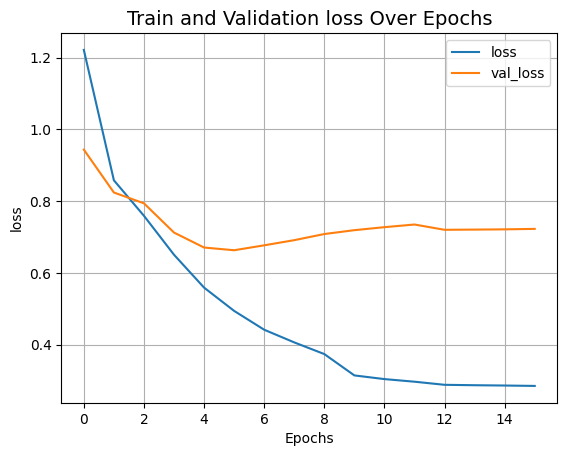

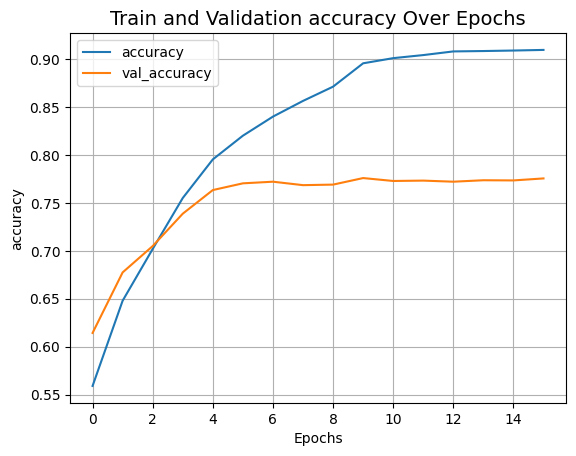

In [55]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [57]:
EmoAkinator1.evaluate(test_dataset)

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7776 - loss: 0.6686


[0.6695597767829895, 0.7667489051818848]